In [16]:
from selenium import webdriver

options = webdriver.ChromeOptions()
options.add_argument('--ignore-ssl-errors=yes')
options.add_argument('--ignore-certificate-errors')
options.add_argument('--headless')

# Connect to the WebDriver
driver = webdriver.Remote(
command_executor='http://localhost:4444/wd/hub',
options=options
)

AttributeError: 'WebDriver' object has no attribute 'connect'

In [19]:
driver.close()

In [1]:
import requests
import pandas as pd
import geopandas as gpd

In [2]:
url = "http://telemetriaws1.ana.gov.br/ServiceANA.asmx/HidroInventario?codEstDE=&codEstATE=&tpEst=&nmEst=&nmRio=&codSubBacia=&codBacia=&nmMunicipio=&nmEstado=&sgResp=&sgOper=&telemetrica="
response = requests.get(url=url)

In [3]:
stations = pd.read_xml(response.content, xpath=".//Table")

In [5]:
stations_geo = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude))

In [6]:
# filter outliers
stations_geo = stations_geo[stations_geo.Longitude > -100]

In [7]:
# get Brazilian boundaries
brazil = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/gadm_410-BRA.geojson", engine="pyogrio")

In [14]:
stations_geo["in_bounds"] = stations_geo.intersects(brazil.iloc[0].geometry)

In [26]:
stations_geo.to_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/water_quality/stations.feather")

---

In [1]:
import os
import requests
from time import sleep
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import chromedriver_binary  # Adds chromedriver binary to path

In [2]:
# Check if the queries.json file already exists in the specified path
if not os.path.exists("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/queries.json"):
    # Load geographic data of stations from a Feather file
    stations_geo = gpd.read_feather("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/stations.feather")
    
    # Filter stations where 'TipoEstacaoQualAgua' equals 1 and select only the 'Codigo' column
    stations_to_query = stations_geo.loc[stations_geo["TipoEstacaoQualAgua"] == 1, ["Codigo"]]
    
    # Initialize a new column 'success' with None values to track query success
    stations_to_query.loc[:, "success"] = None
    
    # Reset the index for a clean DataFrame and set 'Codigo' as the new index
    stations_to_query = stations_to_query.reset_index(drop=True).set_index("Codigo")
    
    # List all files in the raw data directory
    existing_files = os.listdir("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/raw")
    
    # Extract numeric IDs from the file names and filter unique IDs
    existing_file_ids = pd.Series(existing_files).str.extract(r"(^\d*)").squeeze().astype(int).unique()
    
    # Update the 'success' status for stations where corresponding raw data files exist
    stations_to_query.loc[existing_file_ids, "success"] = True
    
    # Save the DataFrame to a JSON file for later use
    stations_to_query.to_json("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/queries.json")


In [3]:
stations_to_query = pd.read_json("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/queries.json")

In [7]:
options = webdriver.ChromeOptions()
options.add_argument('--no-sandbox')  # Bypass OS security model
options.add_argument('--disable-gpu')  # applicable to windows os only
options.add_argument('start-maximized')  # start maximized
options.add_argument('disable-infobars')
options.add_argument('--disable-extensions')
#options.add_argument('--headless')

downloadPath = "/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/raw"
prefs = {}
os.makedirs(downloadPath, exist_ok=True)
prefs["profile.default_content_settings.popups"]=0
prefs["download.default_directory"]=downloadPath
options.add_experimental_option("prefs", prefs)
# Initialize the driver
driver = webdriver.Chrome(options=options)

<selenium.webdriver.remote.webelement.WebElement (session="9f9035660aacb4d5b8a29d8f3231fed0", element="f.535B3A096E99E046028C6D262C7B8930.d.6B0BA2F47F50E3EC83B8796D88AA105E.e.490")>

In [11]:
def download_by_ID(id, driver):
    n_tries = 0
    while n_tries < 5:
        n_tries += 1
        
        if n_tries == 3:
            driver.get("https://www.snirh.gov.br/hidroweb/serieshistoricas")
            WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.XPATH, '//button[@type="reset"]')))
        
        try:
            # clear field
            driver.find_element(By.XPATH, '//button[@type="reset"]').click()
            sleep(.5)
            # enter ID
            driver.find_element(By.XPATH, '//*[@name="codigoEstacao"]').send_keys(str(id))
            sleep(.5)
            # click to search
            driver.find_element(By.XPATH, '//button[@color="primary"]').click()
            # wait for results to load
            element = WebDriverWait(driver, 20).until(
                EC.presence_of_element_located((By.XPATH, '//td[contains(@class, "mat-column-csv")]/button'))
            )
            # download csv
            element.click()
            sleep(1)
            return True
        except:
            sleep(1)
    return False

In [12]:
driver.get("https://www.snirh.gov.br/hidroweb/serieshistoricas")
WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.XPATH, '//button[@type="reset"]')))

for idx in tqdm(stations_to_query[stations_to_query.success.isna()].index):
    stations_to_query.loc[idx, "success"] = download_by_ID(idx, driver)

  6%|▌         | 388/6368 [1:18:24<20:08:31, 12.13s/it]


NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=124.0.6367.119)
Stacktrace:
0   chromedriver                        0x0000000107db57c8 chromedriver + 5916616
1   chromedriver                        0x0000000107dad3e3 chromedriver + 5882851
2   chromedriver                        0x0000000107873a27 chromedriver + 404007
3   chromedriver                        0x000000010784a29e chromedriver + 234142
4   chromedriver                        0x00000001078ea1bd chromedriver + 889277
5   chromedriver                        0x00000001079001a8 chromedriver + 979368
6   chromedriver                        0x00000001078e1613 chromedriver + 853523
7   chromedriver                        0x00000001078b2303 chromedriver + 660227
8   chromedriver                        0x00000001078b2c4e chromedriver + 662606
9   chromedriver                        0x0000000107d736a0 chromedriver + 5645984
10  chromedriver                        0x0000000107d79764 chromedriver + 5670756
11  chromedriver                        0x0000000107d546ae chromedriver + 5519022
12  chromedriver                        0x0000000107d7a279 chromedriver + 5673593
13  chromedriver                        0x0000000107d44ce4 chromedriver + 5455076
14  chromedriver                        0x0000000107d9c9b8 chromedriver + 5814712
15  chromedriver                        0x0000000107d9cb77 chromedriver + 5815159
16  chromedriver                        0x0000000107dad003 chromedriver + 5881859
17  libsystem_pthread.dylib             0x00007ff80cd3b18b _pthread_start + 99
18  libsystem_pthread.dylib             0x00007ff80cd36ae3 thread_start + 15


In [13]:
stations_to_query.to_json("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/queries.json")

In [82]:
driver.close()

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=124.0.6367.119)
Stacktrace:
0   chromedriver                        0x000000010117a7c8 chromedriver + 5916616
1   chromedriver                        0x00000001011723e3 chromedriver + 5882851
2   chromedriver                        0x0000000100c38a27 chromedriver + 404007
3   chromedriver                        0x0000000100c0f29e chromedriver + 234142
4   chromedriver                        0x0000000100caf1bd chromedriver + 889277
5   chromedriver                        0x0000000100cb600c chromedriver + 917516
6   chromedriver                        0x0000000100ca6838 chromedriver + 854072
7   chromedriver                        0x0000000100c77303 chromedriver + 660227
8   chromedriver                        0x0000000100c77c4e chromedriver + 662606
9   chromedriver                        0x00000001011386a0 chromedriver + 5645984
10  chromedriver                        0x000000010113e764 chromedriver + 5670756
11  chromedriver                        0x00000001011196ae chromedriver + 5519022
12  chromedriver                        0x000000010113f279 chromedriver + 5673593
13  chromedriver                        0x0000000101109ce4 chromedriver + 5455076
14  chromedriver                        0x00000001011619b8 chromedriver + 5814712
15  chromedriver                        0x0000000101161b77 chromedriver + 5815159
16  chromedriver                        0x0000000101172003 chromedriver + 5881859
17  libsystem_pthread.dylib             0x00007ff80cd3b18b _pthread_start + 99
18  libsystem_pthread.dylib             0x00007ff80cd36ae3 thread_start + 15


In [18]:
import requests
import re
import pandas as pd

def get_cboTipoReg(option):
    cboTipoReg_values = {
        "Cota": 8, "Cotas": 8, "Vazao": 9, "Vazoes": 9,
        "Chuva": 10, "Chuvas": 10, "Clima": 11, "Qualidade": 12,
        "Resumo": 13, "Sedimento": 14, "Sedimentos": 14, "Perfil": 16
    }
    return {"cboTipoReg": cboTipoReg_values[option]}

def hidroweb_url(station_code):
    return f"http://hidroweb.ana.gov.br/Estacao.asp?Codigo={station_code}&CriaArq=true&TipoArq=1"

def hidroweb_post(url, data):
    response = requests.post(url, data=data)
    return response.text

def find_station_options(content):
    options = re.findall(r'option value="(\d+)">([^<]+)</option>', content)
    return pd.DataFrame(options, columns=['option_num', 'option'])

def extract_metadata(content):
    # Extracting metadata involves parsing the HTML content
    # Simplified example: Assume metadata is extracted as follows:
    data = {
        'station': re.search(r"Station Code: (\d+)", content).group(1),
        'longitude': float(re.search(r"Longitude: ([\d.-]+)", content).group(1)),
        'latitude': float(re.search(r"Latitude: ([\d.-]+)", content).group(1))
    }
    return pd.DataFrame([data])

def download_hydroweb_data(station, option, dest_dir=".", verbose=True):
    url = hidroweb_url(station)
    data = get_cboTipoReg(option)
    content = hidroweb_post(url, data)
    
    if "not found in database" in content:
        print("Station not found")
        return pd.DataFrame(columns=['station', 'file', 'longitude', 'latitude'])
    
    station_options = find_station_options(content)
    selected_option = station_options.query('option == @option')

    metadata = extract_metadata(content)
    
    if verbose:
        print("Metadata extracted:", metadata)
    
    return metadata

# Example usage:
download_hydroweb_data("3253005", "Chuva")

ConnectionError: HTTPConnectionPool(host='hidroweb.ana.gov.br', port=80): Max retries exceeded with url: /Estacao.asp?Codigo=3253005&CriaArq=true&TipoArq=1 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x1501a914d1f0>: Failed to establish a new connection: [Errno 110] Connection timed out'))

In [20]:
response = requests.get(f"https://www.snirh.gov.br/hidroweb/rest/api/estacaotelemetrica?id={10300000}")

In [28]:
response = requests.get(f"https://www.snirh.gov.br/hidroweb/rest/api/documento/gerarTelemetricas?codigosEstacoes=193142390&tipoArquivo=1&periodoInicial=2022-02-11T03:00:00.000Z&periodoFinal=2022-02-12T03:00:00.000Z")

In [29]:
response.content

b'[{"id":193142390,"codigoEstacao":"56696000","codigoAdicional":"56696000","aneelPlu":"1942029","aneelFlu":"56696000","nome":"MARIO DE CARVALHO","latitude":-19.5247,"longitude":-42.6408,"altitude":232,"ultimaAtualizacao":"2023-06-27T03:00:00.000+0000","baciaCodigo":5,"codigoNomeBacia":"5 - Atl\xc3\xa2ntico, Trecho Leste","codigoNomeSubBacia":"56 - RIO DOCE","nomeRio":"RIO PIRACICABA","nomeEstado":"MINAS GERAIS","nomeMunicipio":"TIM\xc3\x93TEO","subBaciaCodigo":56,"rioCodigo":56180000,"estadoCodigo":17,"municipioCodigo":17686000,"responsavelCodigo":1,"operadoraCodigo":1,"menorDataPeriodo":"2010-01-26T21:00:00.000+0000","maiorDataPeriodo":"2024-05-04T10:30:00.000+0000","responsavelSigla":"ANA","operadoraSigla":"CPRM","tipoEstacao":"Hidrol\xc3\xb3gica","operando":1,"codigoNome":"193142390 - MARIO DE CARVALHO","medicoes":[{"id":{"horEstacao":193142390,"horDataHora":"2022-02-11T03:00:00.000+0000"},"horQChuva":0.0,"horChuva":2.2,"horQNivelAdotado":0.0,"horNivelAdotado":380.0,"horQVazao":0.0,

In [4]:
url = f"http://telemetriaws1.ana.gov.br/ServiceANA.asmx/HidroSerieHistorica?codEstacao={10300000}&dataInicio=&dataFim=&tipoDados=2&nivelConsistencia="	
response = requests.get(url=url)

In [12]:
df = pd.read_xml(response.content, xpath=".//SerieHistorica")

In [ ]:
http://hidroweb.ana.gov.br/Estacao.asp?Codigo=XXXXXXXX&CriaArq=true&TipoArq=1

In [13]:
df.columns

Index(['id', 'rowOrder', 'EstacaoCodigo', 'NivelConsistencia', 'DataHora',
       'MediaDiaria', 'TipoMedicaoCotas', 'Maxima', 'Minima', 'Media',
       'DiaMaxima', 'DiaMinima', 'MaximaStatus', 'MinimaStatus', 'MediaStatus',
       'MediaAnualStatus', 'Cota01', 'Cota02', 'Cota03', 'Cota04', 'Cota05',
       'Cota06', 'Cota07', 'Cota08', 'Cota09', 'Cota10', 'Cota11', 'Cota12',
       'Cota13', 'Cota14', 'Cota15', 'Cota16', 'Cota17', 'Cota18', 'Cota19',
       'Cota20', 'Cota21', 'Cota22', 'Cota23', 'Cota24', 'Cota25', 'Cota26',
       'Cota27', 'Cota28', 'Cota29', 'Cota30', 'Cota31', 'DataIns',
       'Cota01Status', 'Cota02Status', 'Cota03Status', 'Cota04Status',
       'Cota05Status', 'Cota06Status', 'Cota07Status', 'Cota08Status',
       'Cota09Status', 'Cota10Status', 'Cota11Status', 'Cota12Status',
       'Cota13Status', 'Cota14Status', 'Cota15Status', 'Cota16Status',
       'Cota17Status', 'Cota18Status', 'Cota19Status', 'Cota20Status',
       'Cota21Status', 'Cota22Status', 'Cot

In [17]:
df.Cota18

0       1471.0
1       1471.0
2       1471.0
3       1471.0
4       1478.0
         ...  
1247     456.0
1248       NaN
1249       NaN
1250       NaN
1251       NaN
Name: Cota18, Length: 1252, dtype: float64

In [12]:
df.columns

Index(['id', 'rowOrder', 'EstacaoCodigo', 'NivelConsistencia', 'DataHora',
       'MediaDiaria', 'TipoMedicaoCotas', 'Maxima', 'Minima', 'Media',
       'DiaMaxima', 'DiaMinima', 'MaximaStatus', 'MinimaStatus', 'MediaStatus',
       'MediaAnualStatus', 'Cota01', 'Cota02', 'Cota03', 'Cota04', 'Cota05',
       'Cota06', 'Cota07', 'Cota08', 'Cota09', 'Cota10', 'Cota11', 'Cota12',
       'Cota13', 'Cota14', 'Cota15', 'Cota16', 'Cota17', 'Cota18', 'Cota19',
       'Cota20', 'Cota21', 'Cota22', 'Cota23', 'Cota24', 'Cota25', 'Cota26',
       'Cota27', 'Cota28', 'Cota29', 'Cota30', 'Cota31', 'DataIns',
       'Cota01Status', 'Cota02Status', 'Cota03Status', 'Cota04Status',
       'Cota05Status', 'Cota06Status', 'Cota07Status', 'Cota08Status',
       'Cota09Status', 'Cota10Status', 'Cota11Status', 'Cota12Status',
       'Cota13Status', 'Cota14Status', 'Cota15Status', 'Cota16Status',
       'Cota17Status', 'Cota18Status', 'Cota19Status', 'Cota20Status',
       'Cota21Status', 'Cota22Status', 'Cot

In [18]:
stations_geo[stations_geo.in_bounds]

,id,rowOrder,BaciaCodigo,SubBaciaCodigo,RioCodigo,RioNome,EstadoCodigo,nmEstado,MunicipioCodigo,nmMunicipio,...,TipoRedeQualAgua,TipoRedeClasseVazao,UltimaAtualizacao,Operando,Descricao,NumImagens,DataIns,DataAlt,geometry,in_bounds
0,Table1,0,3,32,NaN,None,5,PARÁ,5063000,SALINÓPOLIS,...,0.0,0.0,2024-02-21 00:00:00,0,None,0.0,None,2024-02-21 00:00:00,POINT (-47.55000 -0.65000),True
1,Table2,1,3,32,NaN,None,5,PARÁ,5043000,MARACANÃ,...,0.0,0.0,2005-03-29 00:00:00,1,None,0.0,None,None,POINT (-47.50000 -0.83333),True
2,Table3,2,3,32,NaN,None,5,PARÁ,5063000,SALINÓPOLIS,...,0.0,0.0,2024-01-15 00:00:00,1,AUTOMÁTICA - IRIS-1,1.0,None,2024-01-15 00:00:00,POINT (-47.35360 -0.62310),True
3,Table4,3,3,32,NaN,None,5,PARÁ,5029000,CURUÇA,...,0.0,0.0,2018-06-18 00:00:00,1,AUTOMÁTICA - AGSOLV,2.0,None,2018-06-18 00:00:00,POINT (-47.85360 -0.73750),True
4,Table5,4,3,32,NaN,None,5,PARÁ,5061000,PRIMAVERA,...,0.0,0.0,2023-11-07 00:00:00,1,None,1.0,None,2023-11-07 00:00:00,POINT (-47.09940 -0.92940),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38055,Table38056,38055,8,88,88100000.0,CANAL DE SÃO GONÇALO,24,RIO GRANDE DO SUL,24144000,PELOTAS,...,0.0,1.0,2018-02-02 00:00:00,0,None,0.0,None,2018-02-02 00:00:00,POINT (-52.33330 -31.78220),True
38056,Table38057,38056,8,88,88100000.0,CANAL DE SÃO GONÇALO,24,RIO GRANDE DO SUL,24144000,PELOTAS,...,0.0,0.0,2017-03-28 00:00:00,0,None,0.0,None,2017-03-28 00:00:00,POINT (-52.22810 -31.78640),True
38057,Table38058,38057,8,88,88105000.0,ARROIO PELOTAS,24,RIO GRANDE DO SUL,24144000,PELOTAS,...,3.0,0.0,2018-02-01 00:00:00,1,None,0.0,2015-04-27 00:00:00,2018-02-01 00:00:00,POINT (-52.28310 -31.75750),True
38058,Table38059,38058,8,88,88105000.0,ARROIO PELOTAS,24,RIO GRANDE DO SUL,24144000,PELOTAS,...,3.0,1.0,2018-12-06 00:00:00,1,None,0.0,None,2018-12-06 00:00:00,POINT (-52.46250 -31.57360),True


In [33]:
stations_geo.within(brazil.unary_union)

In [30]:
stations_geo[stations_geo.intersects(brazil.geometry.iloc[0])].plot()

KeyboardInterrupt: 

In [ ]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'satellite-cloud-properties',
    {
        'format': 'tgz',
        'product_family': 'clara_a3',
        'origin': 'eumetsat',
        'variable': 'cloud_fraction',
        'year': [
            '1979', '1980', '1981',
            '1982', '1983', '1984',
            '1985', '1986', '1987',
            '1988', '1989', '1990',
            '1991', '1992', '1993',
            '1994', '1995', '1996',
            '1997', '1998', '1999',
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019', '2020',
        ],
        'time_aggregation': 'monthly_mean',
        'climate_data_record_type': 'thematic_climate_data_record',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'area': [
            90, -180, -90,
            180,
        ],
    },
    'download.tar.gz')

---

In [58]:
import numpy as np
import pandas as pd
import zipfile
import seaborn as sns
import os
from datetime import datetime

In [6]:
root_path = "/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/raw/"

In [7]:
files = pd.DataFrame({"filename": os.listdir(root_path)})
files["filesize"] = files.filename.apply(lambda x: os.path.getsize(f"{root_path}{x}"))
files["file_id"] = files.filename.str.extract(r"(^\d*)").iloc[:,0]
files = files.loc[((files.filesize > 22) & ~(files.file_id == "") & files.filename.str.contains(r"_csv.zip")),:]
files["file_id"] = files.file_id.astype(int)

In [9]:
dfs = [None] * files.shape[0]
for i in range(files.shape[0]):
    # open zip file
    with zipfile.ZipFile(f"{root_path}{files.filename.iloc[i]}", "r") as z:
        # prepare name of file in zipfile
        t_csvname = f"{files.file_id.iloc[i]}_QualAgua.csv"
        # check if a water quality file exists
        if t_csvname in [x.filename for x in z.filelist]:
            # get number of header lines to skip
            with z.open(t_csvname) as f:
                t_it = ""
                while not "EstacaoCodigo" in t_it:
                    t_it = f.readline().decode("latin-1")
                dfs[i] = pd.read_csv(f, names=t_it.split(";"), delimiter=";", encoding="latin-1")
        else: 
            dfs[i] = pd.DataFrame()

In [10]:
dfs = [y for y in [x for x in dfs if x is not None] if not y.empty]

In [11]:
dfs = pd.concat(dfs).copy()

In [ ]:
dfs[["pH", "OD", "TempAmostra", "Turbidez"]] = dfs[["pH", "OD", "TempAmostra", "Turbidez"]].apply(lambda x: x.str.replace(",", ".").astype(float), axis = 0)
dfs["Data"] = dfs["Data"].str.replace("/3", "/2")
dfs["date"] = pd.to_datetime(dfs["Data"], format="mixed", dayfirst=True)

In [71]:
dfs.to_feather("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/quality_indicators.feather")

---

In [6]:
from datetime import datetime
import pandas as pd
import geopandas as gpd
import seaborn as sns

In [2]:
dfs = pd.read_feather("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/quality_indicators.feather")

In [14]:
dfs.loc[:,(dfs.isna().mean() < .5)]

,EstacaoCodigo,NivelConsistencia,Data,Hora,Choveu,TempAr,TempAmostra,pH,Turbidez,DBO,OD,SolTotais,NitrogenioAmoniacal,Nitratos,date
0,48839000,1.0,07/09/2022,15:29,2.0,"27,0",26.0,6.88,NaN,"4,0",7.30,"188,0",None,"0,08",2022-09-07
1,48839000,1.0,08/06/2022,15:50,2.0,"26,0",26.0,7.00,10.04,"1,67",6.20,"252,0",None,"0,08",2022-06-08
2,48839000,1.0,02/12/2021,07:40,1.0,"29,0",26.0,7.85,10.51,"0,85",6.00,"224,0",None,"0,08",2021-12-02
3,48839000,1.0,03/03/2021,10:00,1.0,"28,0",29.0,7.41,5.00,"2,8",5.20,"298,0",None,"0,08",2021-03-03
4,48839000,1.0,25/09/2019,10:30,0.0,"32,0",28.0,8.70,8.70,"3,6",9.50,"198,0","0,07","0,08",2019-09-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,66855000,1.0,26/05/2008,09:00,0.0,"19,0",21.4,6.85,NaN,None,8.76,None,None,None,2008-05-26
39,66855000,1.0,25/10/2007,12:00,1.0,"27,4",25.2,6.56,NaN,None,7.40,None,None,None,2007-10-25
40,66855000,1.0,04/07/2007,10:00,0.0,"24,6",20.3,7.28,NaN,None,8.07,None,None,None,2007-07-04
41,66855000,1.0,06/09/2003,11:10,0.0,"35,8",27.5,7.54,NaN,None,5.70,None,None,None,2003-09-06


In [7]:
plot_data = dfs.loc[:,["date", "pH", "EstacaoCodigo"]].reset_index()
# remove outliers
plot_data = plot_data.loc[((plot_data.pH < 12) & (plot_data.date < datetime.now())),:]

<Axes: xlabel='date', ylabel='pH'>

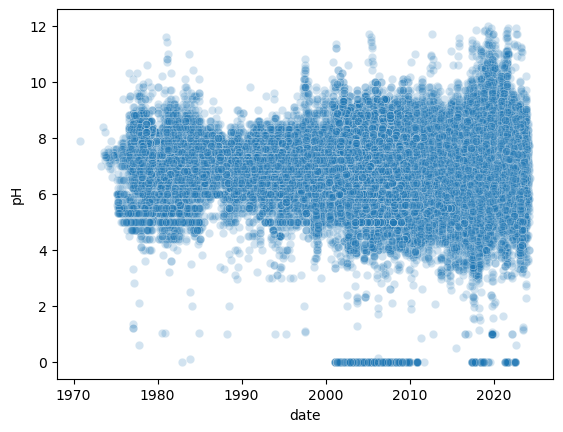

In [8]:
sns.scatterplot(x = "date", y = "pH", alpha = .2, data = plot_data)

<Axes: xlabel='date', ylabel='pH'>

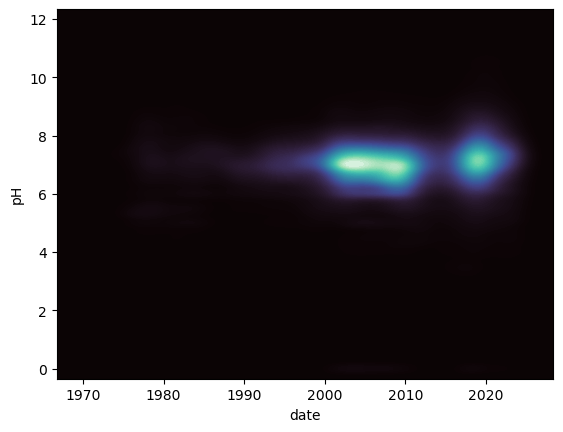

In [62]:
sns.kdeplot(x = "date", y = "pH", fill=True, thresh=0, levels=100, cmap="mako", data = plot_data)

---

In [66]:
import numpy as np
import pandas as pd
import geopandas as gpd

In [17]:
stations = gpd.read_feather("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/stations.feather")
water_quality = pd.read_feather("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/quality_indicators.feather")

<Axes: >

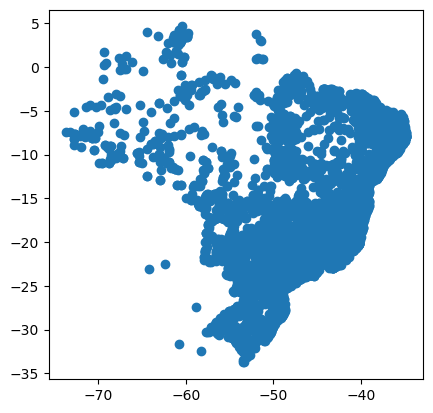

In [78]:
stations.loc[stations.Codigo.isin(water_quality.EstacaoCodigo.unique()),:].plot()

In [18]:
rivers = gpd.read_feather("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/river_network/shapefile.feather")
topology = gpd.read_feather("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/river_network/topology.feather")

In [19]:
import sys
sys.path.append("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/code")
from data.preprocess.river_network import calculate_distance_from_estuary

rivers = calculate_distance_from_estuary(rivers, topology)

In [20]:
stations_rivers = gpd.sjoin_nearest(stations.set_crs(4326).to_crs(5641), rivers)

In [ ]:
import json
upstream_ids = json.load(open("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/river_network/reachability_municipalities.json", "r"))

In [30]:
upstream_ids[508616]

KeyError: 508616

In [26]:
stations_rivers

,id,rowOrder,BaciaCodigo,SubBaciaCodigo,RioCodigo,RioNome,EstadoCodigo,nmEstado,MunicipioCodigo,nmMunicipio,...,CORIO,downstream_node_id,upstream_node_id,adm2,estuary,river,segment,subsegment,distance_from_estuary,segment_offset
0,Table1,0,3,32,NaN,None,5,PARÁ,5063000,SALINÓPOLIS,...,71136_0,NaN,508616.0,2484.0,64.0,0.0,0.0,0.0,0.000000e+00,0.000000
1,Table2,1,3,32,NaN,None,5,PARÁ,5043000,MARACANÃ,...,71138_0,90603.0,90497.0,2484.0,184.0,0.0,1.0,0.0,2.676206e+03,676.206261
2,Table3,2,3,32,NaN,None,5,PARÁ,5063000,SALINÓPOLIS,...,711532_0,NaN,509884.0,2522.0,144.0,0.0,0.0,0.0,0.000000e+00,0.000000
3,Table4,3,3,32,NaN,None,5,PARÁ,5029000,CURUÇA,...,71118_0,NaN,507182.0,2462.0,213.0,0.0,0.0,0.0,0.000000e+00,0.000000
4,Table5,4,3,32,NaN,None,5,PARÁ,5061000,PRIMAVERA,...,71158_0,NaN,511017.0,2516.0,393.0,0.0,0.0,0.0,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38102,Table38103,38102,9,90,90000000.0,OUTROS RIOS,68,EQUADOR,68000000,EQUADOR,...,None,433.0,418329.0,NaN,136.0,11282.0,2.0,0.0,4.748772e+06,771.732916
38103,Table38104,38103,9,90,90000000.0,OUTROS RIOS,68,EQUADOR,68000000,EQUADOR,...,None,188.0,177.0,NaN,136.0,10597.0,3.0,0.0,4.647725e+06,725.436407
38104,Table38105,38104,9,90,90000000.0,OUTROS RIOS,68,EQUADOR,68000000,EQUADOR,...,None,46.0,417981.0,NaN,136.0,10404.0,0.0,0.0,4.714851e+06,851.395155
38105,Table38106,38105,9,90,90000000.0,OUTROS RIOS,68,EQUADOR,68000000,EQUADOR,...,None,46.0,417981.0,NaN,136.0,10404.0,0.0,0.0,4.714851e+06,851.395155


In [21]:
stations = stations.join(stations_rivers.loc[:,["adm2", "estuary", "distance_from_estuary"]])

In [24]:
stations.columns

Index(['id', 'rowOrder', 'BaciaCodigo', 'SubBaciaCodigo', 'RioCodigo',
       'RioNome', 'EstadoCodigo', 'nmEstado', 'MunicipioCodigo', 'nmMunicipio',
       'ResponsavelCodigo', 'ResponsavelSigla', 'ResponsavelUnidade',
       'ResponsavelJurisdicao', 'OperadoraCodigo', 'OperadoraSigla',
       'OperadoraUnidade', 'OperadoraSubUnidade', 'TipoEstacao', 'Codigo',
       'Nome', 'CodigoAdicional', 'Latitude', 'Longitude', 'Altitude',
       'AreaDrenagem', 'TipoEstacaoEscala', 'TipoEstacaoRegistradorNivel',
       'TipoEstacaoDescLiquida', 'TipoEstacaoSedimentos',
       'TipoEstacaoQualAgua', 'TipoEstacaoPluviometro',
       'TipoEstacaoRegistradorChuva', 'TipoEstacaoTanqueEvapo',
       'TipoEstacaoClimatologica', 'TipoEstacaoPiezometria',
       'TipoEstacaoTelemetrica', 'PeriodoEscalaInicio', 'PeriodoEscalaFim',
       'PeriodoRegistradorNivelInicio', 'PeriodoRegistradorNivelFim',
       'PeriodoDescLiquidaInicio', 'PeriodoDescLiquidaFim',
       'PeriodoSedimentosInicio', 'PeriodoSe

In [141]:
import os 
files = pd.Series(os.listdir("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/land_cover/temp_extracted_land_cover"))
files = files[files.str.contains("feather")]

In [166]:
files

0     933.feather
1     493.feather
2     331.feather
3     574.feather
4     602.feather
         ...     
63    287.feather
64    148.feather
65    535.feather
66    792.feather
67    557.feather
Length: 68, dtype: object

In [171]:
pd.read_feather(f"/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/land_cover/temp_extracted_land_cover/{493}.feather")

1      3  4  5  6  49  10  11  12  32  ...  mining  water  \
grid_id index                                         ...                  
450     0      0   6809  0  0  0   0   0   0   0   0  ...       0      0   
        2      0    443  0  0  0   0   0   0   0   0  ...       0      0   
        3      0   3548  0  0  0   0   0   0   0   0  ...       0      0   
        4      0   3362  0  0  0   0   0   0   0   0  ...       0      0   
        5      0    564  0  0  0   0   0   0   0   0  ...       0      0   
...           ..    ... .. .. ..  ..  ..  ..  ..  ..  ...     ...    ...   
        2767   0  18687  0  0  0   0   0   0   0   0  ...       0      0   
        2768   0   1692  0  0  0   0   0   0   0   0  ...       0      0   
        2769   0  17676  0  0  0   0   0   0   0   0  ...       0      0   
        2770   0   2428  0  0  0   0   0   0   0   0  ...       0      0   
        2771   0   1159  0  0  0   0   0   0   0   0  ...       0      0   

               deforestation  deforestation_f  deforestation_p  \
grid_id index                                                    
450     0                  0                0                0   
        2                  0                0                0   
        3                  0                0                0   
        4                  0                0                0   
        5                  0                0                0   
...                      ...              ...              ...   
        2767              46               46               40   
        2768               0                0                0   
        2769              26               26                0   
        2770               0                0                0   
        2771               0                0                0   

               deforestation_a  deforestation_u  deforestation_m  year   0  
grid_id index                                                               
450     0                    0                0                0  1986 NaN  
        2                    0                0                0  1986 NaN  
        3                    0                0                0  1986 NaN  
        4                    0                0                0  1986 NaN  
        5                    0                0                0  1986 NaN  
...                        ...              ...              ...   ...  ..  
        2767                 6                0                0  2022 NaN  
        2768                 0                0                0  2022 NaN  
        2769                26                0                0  2022 NaN  
        2770                 0                0                0  2022 NaN  
        2771                 0                0                0  2022 NaN  

[68709 rows x 56 columns]

In [143]:
land_cover = pd.concat([pd.read_feather(f"/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/land_cover/temp_extracted_land_cover/{x}") for x in files])
land_cover.index.names = [None, None]

In [145]:
drainage_polygons = gpd.read_feather("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/drainage/extracted_drainage_polygons.feather")

In [167]:
land_cover.index.get_level_values(0).unique()

Index([921, 450, 449, 533, 134, 419, 534, 220], dtype='int64')

<Axes: >

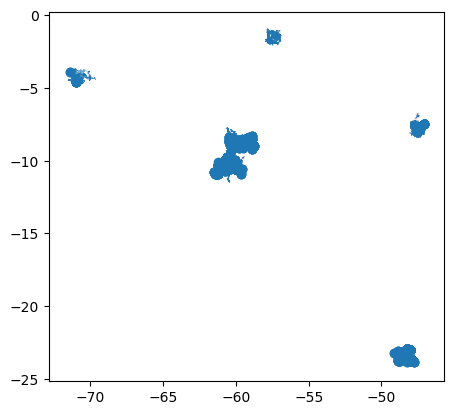

In [163]:
drainage_polygons.join(land_cover.query("year==2017"), how = "inner").plot()

In [146]:
drainage_polygons

estuary    river  segment  subsegment  distance_from_estuary  \
602  0       136.0  41388.0      0.0         0.0           3.468000e+06   
     1       136.0  41388.0      0.0         0.0           3.467000e+06   
     2       136.0  41388.0      0.0         0.0           3.466000e+06   
     3       136.0  41388.0      0.0         0.0           3.465000e+06   
     4       136.0  41388.0      0.0         0.0           3.464000e+06   
...            ...      ...      ...         ...                    ...   
1022 1519     29.0    170.0      0.0         0.0           3.260000e+05   
     1520     29.0    170.0      0.0         0.0           3.250000e+05   
     1521     29.0    170.0      0.0         0.0           3.240000e+05   
     1522     29.0    170.0      0.0         0.0           3.230000e+05   
     1523     29.0    170.0      0.0         0.0           3.227077e+05   

                                                    geometry  
602  0     MULTIPOLYGON (((-62.57772 -12.67584, -62.57712...  
     1     POLYGON ((-62.50037 -12.68141, -62.49949 -12.6...  
     2                                                  None  
     3                                                  None  
     4                                                  None  
...                                                      ...  
1022 1519  POLYGON ((-53.83375 -32.61792, -53.83458 -32.6...  
     1520  POLYGON ((-53.80375 -32.62292, -53.80375 -32.6...  
     1521  GEOMETRYCOLLECTION (POINT (-53.94517 -32.43767...  
     1522                                               None  
     1523                                               None  

[2726217 rows x 6 columns]

In [144]:
land_cover

1      3      4  5  6  49  10  11   12  32  ...  mining  water  \
grid_id index                                              ...                  
921     0      0  10583      0  0  0   0   0   0    0   0  ...       0      0   
        4      0   3463      0  0  0   0   0   0    0   0  ...       0      0   
        5      0    965      0  0  0   0   0   0    0   0  ...       0      0   
        6      0   2092      0  0  0   0   0   0    0   0  ...       0      6   
        7      0   1100      0  0  0   0   0   0    0   0  ...       0      0   
...           ..    ...    ... .. ..  ..  ..  ..  ...  ..  ...     ...    ...   
534     2641   0      0    706  0  0   0   0   0    0   0  ...       0      0   
        2642   0      0   1815  0  0   0   0   0   21   0  ...       0      0   
        2643   0      0  10559  0  0   0   0   0  481   0  ...       0      0   
        2646   0      0     64  0  0   0   0   0    1   0  ...       0      0   
        2647   0      0   1522  0  0   0   0   0    8   0  ...       0      0   

               deforestation  deforestation_f  deforestation_p  \
grid_id index                                                    
921     0                361              361                0   
        4                  8                8                0   
        5                268              268                0   
        6                123              121                0   
        7                  6                6                0   
...                      ...              ...              ...   
534     2641               1                1                1   
        2642               0                0                0   
        2643               5                5                0   
        2646               0                0                0   
        2647               1                1                1   

               deforestation_a  deforestation_u  deforestation_m  year   0  
grid_id index                                                               
921     0                    0                0                0  1986 NaN  
        4                    0                0                0  1986 NaN  
        5                    0                0                0  1986 NaN  
        6                    0                0                0  1986 NaN  
        7                    0                0                0  1986 NaN  
...                        ...              ...              ...   ...  ..  
534     2641                 0                0                0  2022 NaN  
        2642                 0                0                0  2022 NaN  
        2643                 0                0                0  2022 NaN  
        2646                 0                0                0  2022 NaN  
        2647                 0                0                0  2022 NaN  

[4412176 rows x 56 columns]

<Axes: >

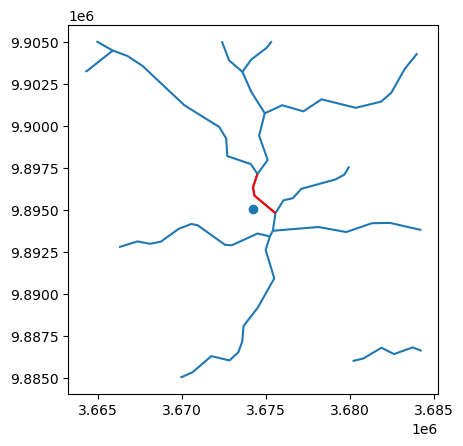

In [121]:
i = 50
# 
bbox = test.iloc[i].geometry.xy
ax = rivers.clip([bbox[0][0] - 10000, bbox[1][0] - 10000, bbox[0][0] + 10000, bbox[1][0]+ 10000]).plot()
test.iloc[[i]].plot(ax=ax)
rivers.loc[[tuple(test.iloc[i][["index_right0", "index_right1", "index_right2"]])]].plot(ax=ax, color="red")

In [80]:
rivers

NORIOCOMP        CORIO  \
0      0 0                                          Água Azul    8641516_0   
1      0 0                                        Água Bonita  864142512_0   
2      0 0                                        Água Bonita    8962984_0   
3      0 0  Água Bonita ou das Pontinhas e Água do Capão B...   86432922_0   
         1  Água Bonita ou das Pontinhas e Água do Capão B...   86432922_0   
...                                                       ...          ...   
161531 0 0                                               None         None   
161532 0 0                                               None         None   
161533 0 0                                               None         None   
161534 0 0                                               None         None   
161535 0 0                                               None         None   

            downstream_node_id  upstream_node_id    adm2  estuary    river  \
0      0 0             75450.0          493402.0  3110.0    228.0   9478.0   
1      0 0             75974.0          494325.0  2954.0    228.0   9551.0   
2      0 0             67065.0          485868.0  1559.0    228.0  12434.0   
3      0 0            153605.0          498582.0  4759.0    228.0   9153.0   
         1            153606.0          153605.0  4759.0    228.0   9153.0   
...                        ...               ...     ...      ...      ...   
161531 0 0                 NaN          487842.0     NaN   1023.0      0.0   
161532 0 0             68579.0          486433.0     NaN   1024.0      0.0   
161533 0 0             68579.0          486793.0     NaN   1024.0      1.0   
161534 0 0             67656.0           67491.0     NaN     60.0     28.0   
161535 0 0                 NaN           68579.0     NaN   1024.0      0.0   

            segment  subsegment  \
0      0 0      0.0         0.0   
1      0 0      0.0         0.0   
2      0 0      0.0         0.0   
3      0 0      2.0         0.0   
         1      1.0         0.0   
...             ...         ...   
161531 0 0      0.0         0.0   
161532 0 0      1.0         0.0   
161533 0 0      0.0         0.0   
161534 0 0      0.0         0.0   
161535 0 0      0.0         0.0   

                                                     geometry  
0      0 0  LINESTRING (4010130.381 7424922.032, 4011257.1...  
1      0 0  LINESTRING (4037777.378 7384298.361, 4037034.2...  
2      0 0  LINESTRING (3804922.764 8019931.350, 3804511.2...  
3      0 0  LINESTRING (4176882.178 7440871.707, 4175687.8...  
         1  LINESTRING (4170252.538 7442847.873, 4170252.1...  
...                                                       ...  
161531 0 0  LINESTRING (3849965.585 10605057.641, 3850608....  
161532 0 0  LINESTRING (3818121.855 10606360.696, 3818074....  
161533 0 0  LINESTRING (3826386.147 10608748.764, 3826293....  
161534 0 0  LINESTRING (3797879.886 10615132.380, 3797842....  
161535 0 0  LINESTRING (3822757.940 10616623.770, 3822687....  

[542107 rows x 10 columns]

---

In [1]:
import pandas as pd
import geopandas as gpd

In [41]:
test = pd.read_csv("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/13150000_QualAgua.csv", sep=";", encoding="latin1", skiprows=16)

test[["pH", "OD", "TempAmostra", "Turbidez"]] = test[["pH", "OD", "TempAmostra", "Turbidez"]].apply(lambda x: x.str.replace(",", ".").astype(float), axis = 0)
test["date"] = pd.to_datetime(test["Data"], format="%d/%m/%Y")

In [29]:
test.loc[:,(test.isna().mean() < .5)]

,EstacaoCodigo,NivelConsistencia,Data,Hora,NumMedicao,PosHorizColeta,PosVertColeta,Choveu,TempAmostra,pH,Turbidez,CondutividadeEletrica,OD,date
0,13150000,1,12/10/2023,17:48,255.0,3,2.0,0.0,"31,9",7.23,"29,1",NaN,"5,87",2023-10-12
1,13150000,1,12/10/2023,18:11,255.0,1,2.0,0.0,"31,8",7.33,"27,1",NaN,"5,77",2023-10-12
2,13150000,1,12/10/2023,18:19,255.0,2,2.0,0.0,"31,9",7.35,"29,9",NaN,"5,82",2023-10-12
3,13150000,1,16/06/2023,16:50,254.0,2,2.0,0.0,"27,5",6.80,"38,3",NaN,"2,91",2023-06-16
4,13150000,1,16/06/2023,17:00,254.0,1,2.0,0.0,"27,6",6.82,"58,5",NaN,"3,0",2023-06-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,13150000,1,07/06/1975,15:10,5.0,1,3.0,0.0,"27,2",5.50,NaN,"54,1",NaN,1975-06-07
309,13150000,1,07/05/1975,16:00,4.0,1,3.0,0.0,"27,6",6.00,NaN,"109,0",NaN,1975-05-07
310,13150000,1,28/04/1975,14:40,3.0,1,3.0,0.0,"28,2",6.00,NaN,NaN,NaN,1975-04-28
311,13150000,1,08/04/1975,15:30,2.0,1,3.0,0.0,"27,8",6.00,NaN,NaN,NaN,1975-04-08


<Axes: xlabel='Data'>

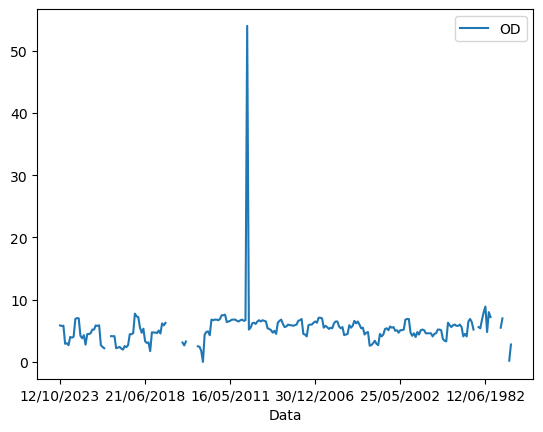

In [34]:
test.loc[:,["Data", "OD"]].plot(x="Data", y = "OD", kind="line")

<Axes: xlabel='Data'>

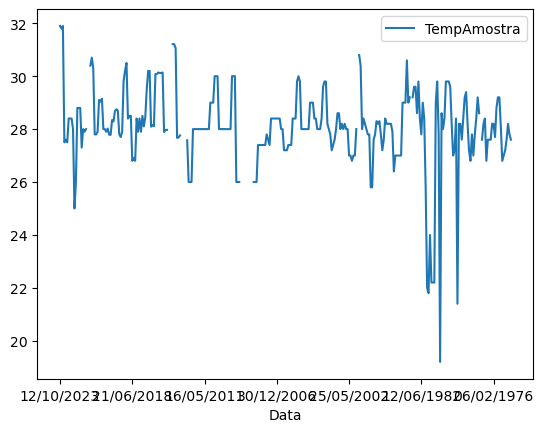

In [40]:
test.loc[:,["Data", "TempAmostra"]].plot(x="Data", y = "TempAmostra", kind="line")

<Axes: xlabel='Data'>

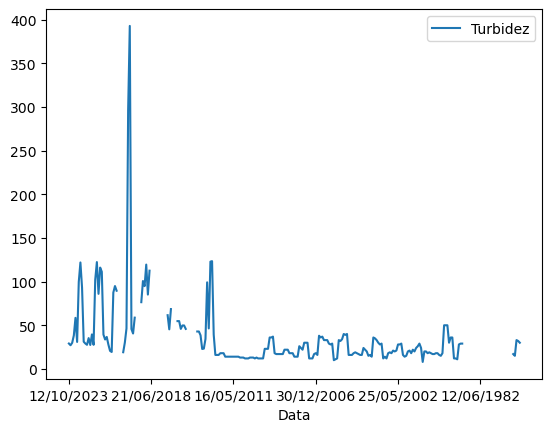

In [42]:
test.loc[:,["Data", "Turbidez"]].plot(x="Data", y = "Turbidez", kind="line")

<Axes: xlabel='Data'>

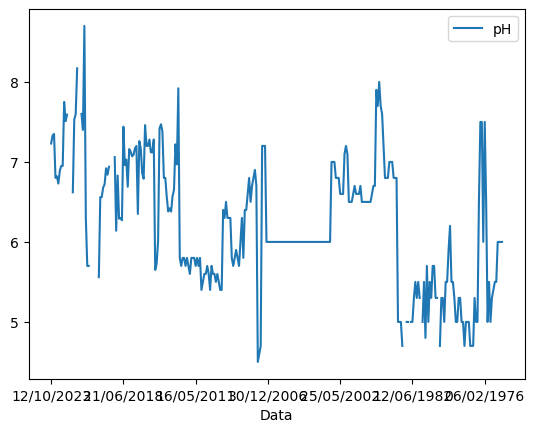

In [30]:
test.loc[:,["Data", "pH"]].plot(x="Data", y = "pH", kind="line")